In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, mean_absolute_error, mean_squared_error
)

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

In [4]:
# Загрузка Restaurant Reviews
reviews = pd.read_csv("Restaurant_Reviews.csv", sep='\t')
print("Restaurant Reviews загружен")
print(reviews.shape)
reviews.head()

Restaurant Reviews загружен
(1000, 2)


,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [5]:
# Загрузка NY Pricing
ny = pd.read_csv("NY Realstate Pricing.csv")
print("\nNY Realstate Pricing загружен")
print(ny.shape)
ny.head()


NY Realstate Pricing загружен
(17614, 12)


,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,0,29,49,0.38,365
4,4,5178,Manhattan,40.76489,-73.98493,Private room,79,141,2,454,3.52,242


In [6]:
print("Restaurant Reviews — распределение классов:")
print(reviews['Liked'].value_counts())

print("\nNY Pricing — статистика цены:")
ny['price'].describe()

Restaurant Reviews — распределение классов:
Liked
1    500
0    500
Name: count, dtype: int64

NY Pricing — статистика цены:


count    17614.000000
mean       145.455490
std        194.990677
min          0.000000
25%         70.000000
50%        109.000000
75%        170.000000
max       9999.000000
Name: price, dtype: float64

C:\Users\fedor\AppData\Local\Temp\ipykernel_28484\3956717919.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=reviews, x='Liked', ax=axes[1], palette='husl')


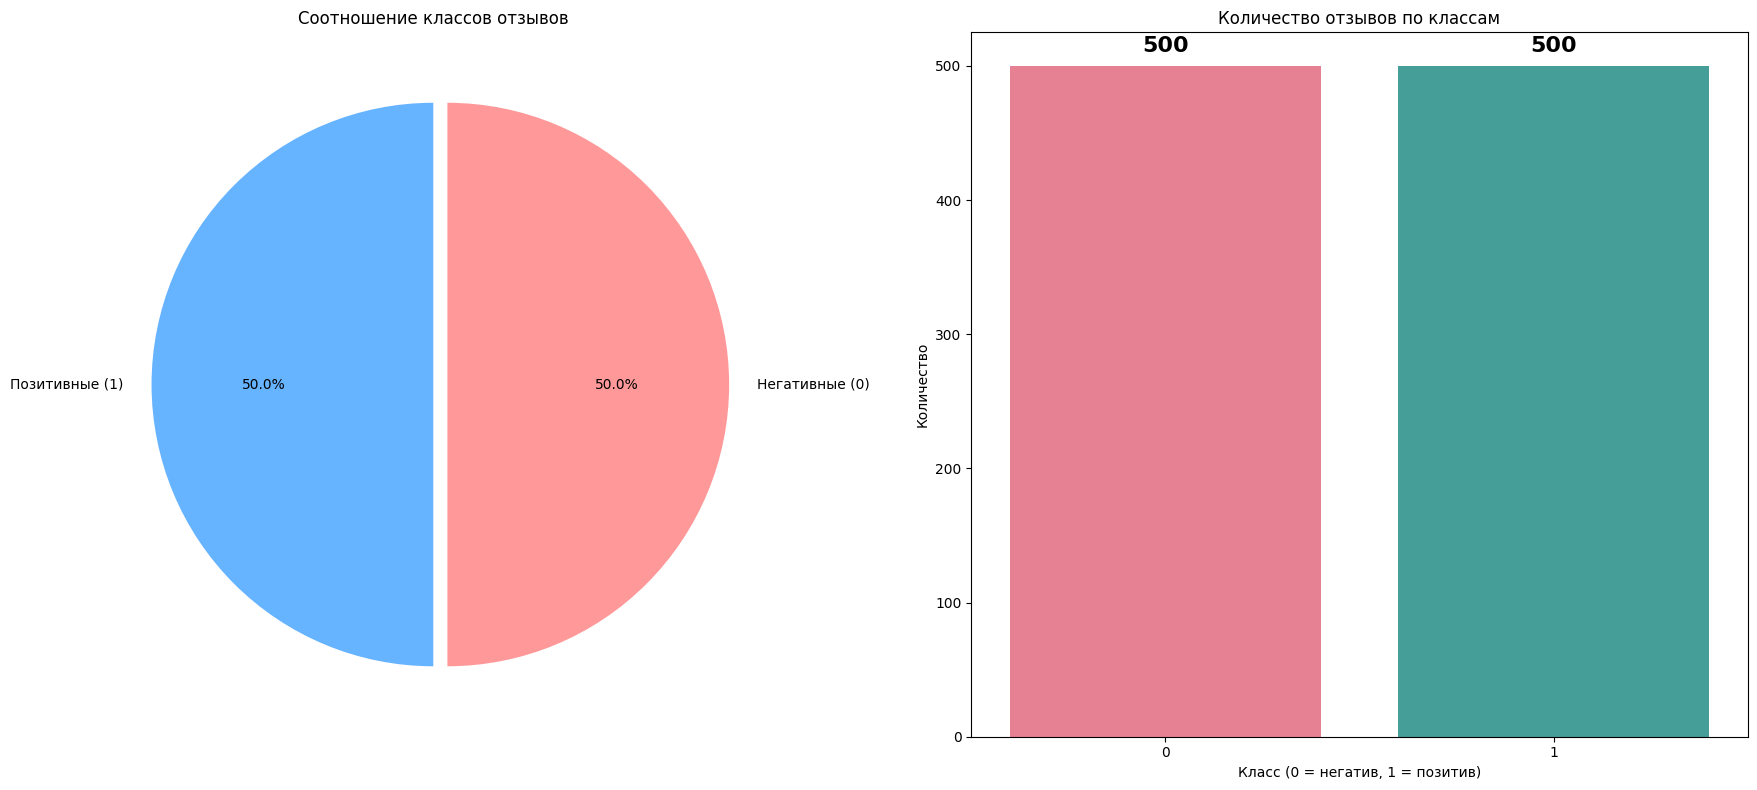

Позитивных отзывов: 500 (50.0%)
Негативных отзывов: 500 (50.0%)


In [7]:
# Круговая + столбчатая диаграмма распределения классов в Restaurant Reviews
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

likes_count = reviews['Liked'].value_counts()
axes[0].pie(likes_count.values, labels=['Позитивные (1)', 'Негативные (0)'], 
            autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'], explode=(0, 0.05))
axes[0].set_title('Соотношение классов отзывов')

sns.countplot(data=reviews, x='Liked', ax=axes[1], palette='husl')
axes[1].set_title('Количество отзывов по классам')
axes[1].set_xlabel('Класс (0 = негатив, 1 = позитив)')
axes[1].set_ylabel('Количество')
for i, v in enumerate(likes_count.values):
    axes[1].text(i, v + 10, str(v), ha='center', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Позитивных отзывов: {likes_count[1]} ({likes_count[1]/len(reviews)*100:.1f}%)")
print(f"Негативных отзывов: {likes_count[0]} ({likes_count[0]/len(reviews)*100:.1f}%)")

C:\Users\fedor\AppData\Local\Temp\ipykernel_28484\2918912959.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=reviews, x='Liked', y='length', palette='husl', ax=axes[1])


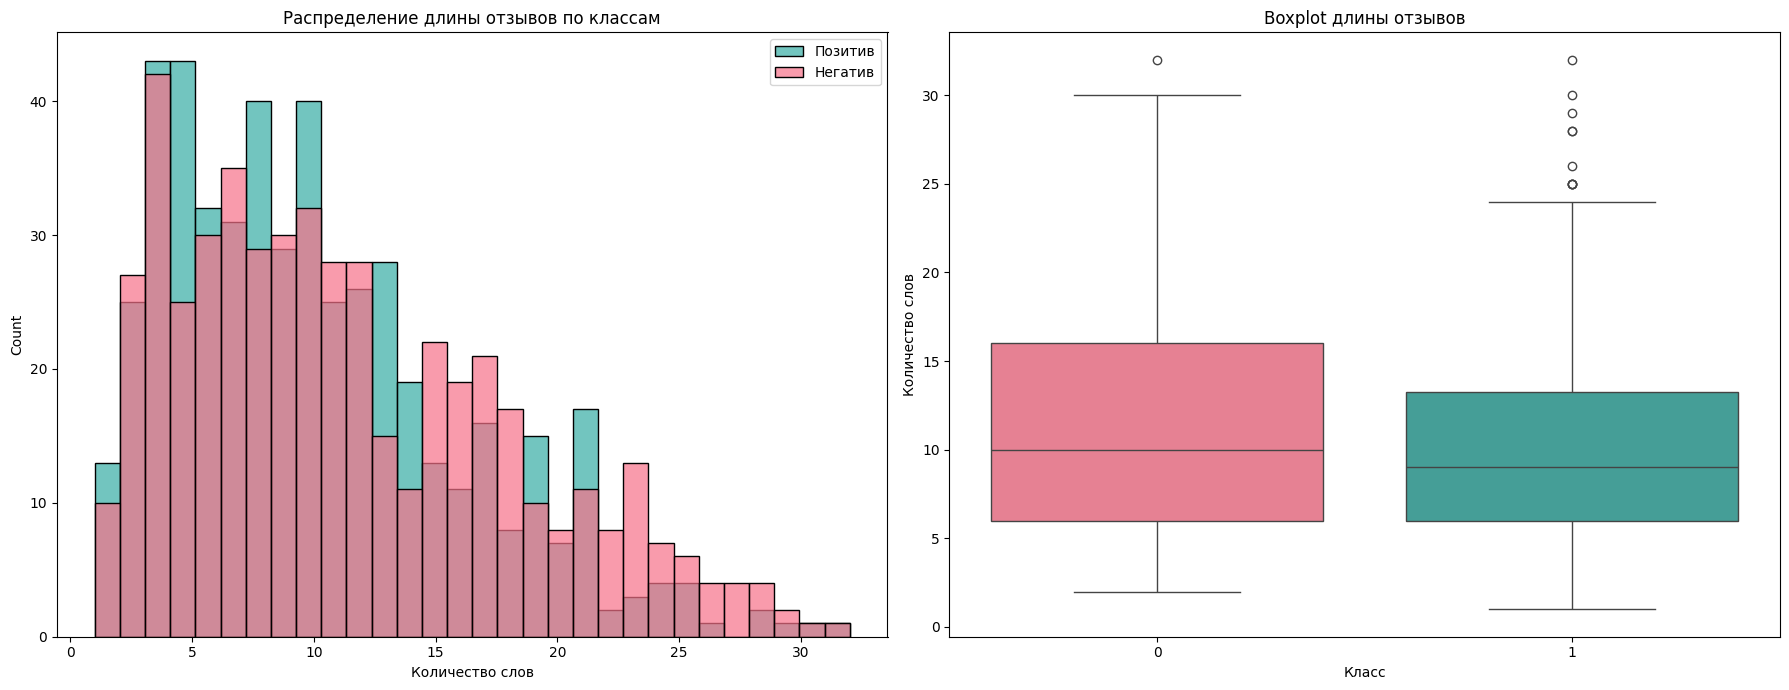

Средняя длина отзыва:
Liked
0    11.498
1    10.290
Name: length, dtype: float64


In [8]:
# Добавляем длину текста
reviews['length'] = reviews['Review'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Гистограмма длин
sns.histplot(data=reviews, x='length', hue='Liked', palette='husl', bins=30, ax=axes[0], alpha=0.7)
axes[0].set_title('Распределение длины отзывов по классам')
axes[0].set_xlabel('Количество слов')
axes[0].legend(['Позитив', 'Негатив'])

# Boxplot
sns.boxplot(data=reviews, x='Liked', y='length', palette='husl', ax=axes[1])
axes[1].set_title('Boxplot длины отзывов')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Количество слов')

plt.tight_layout()
plt.show()

print("Средняя длина отзыва:")
print(reviews.groupby('Liked')['length'].mean())

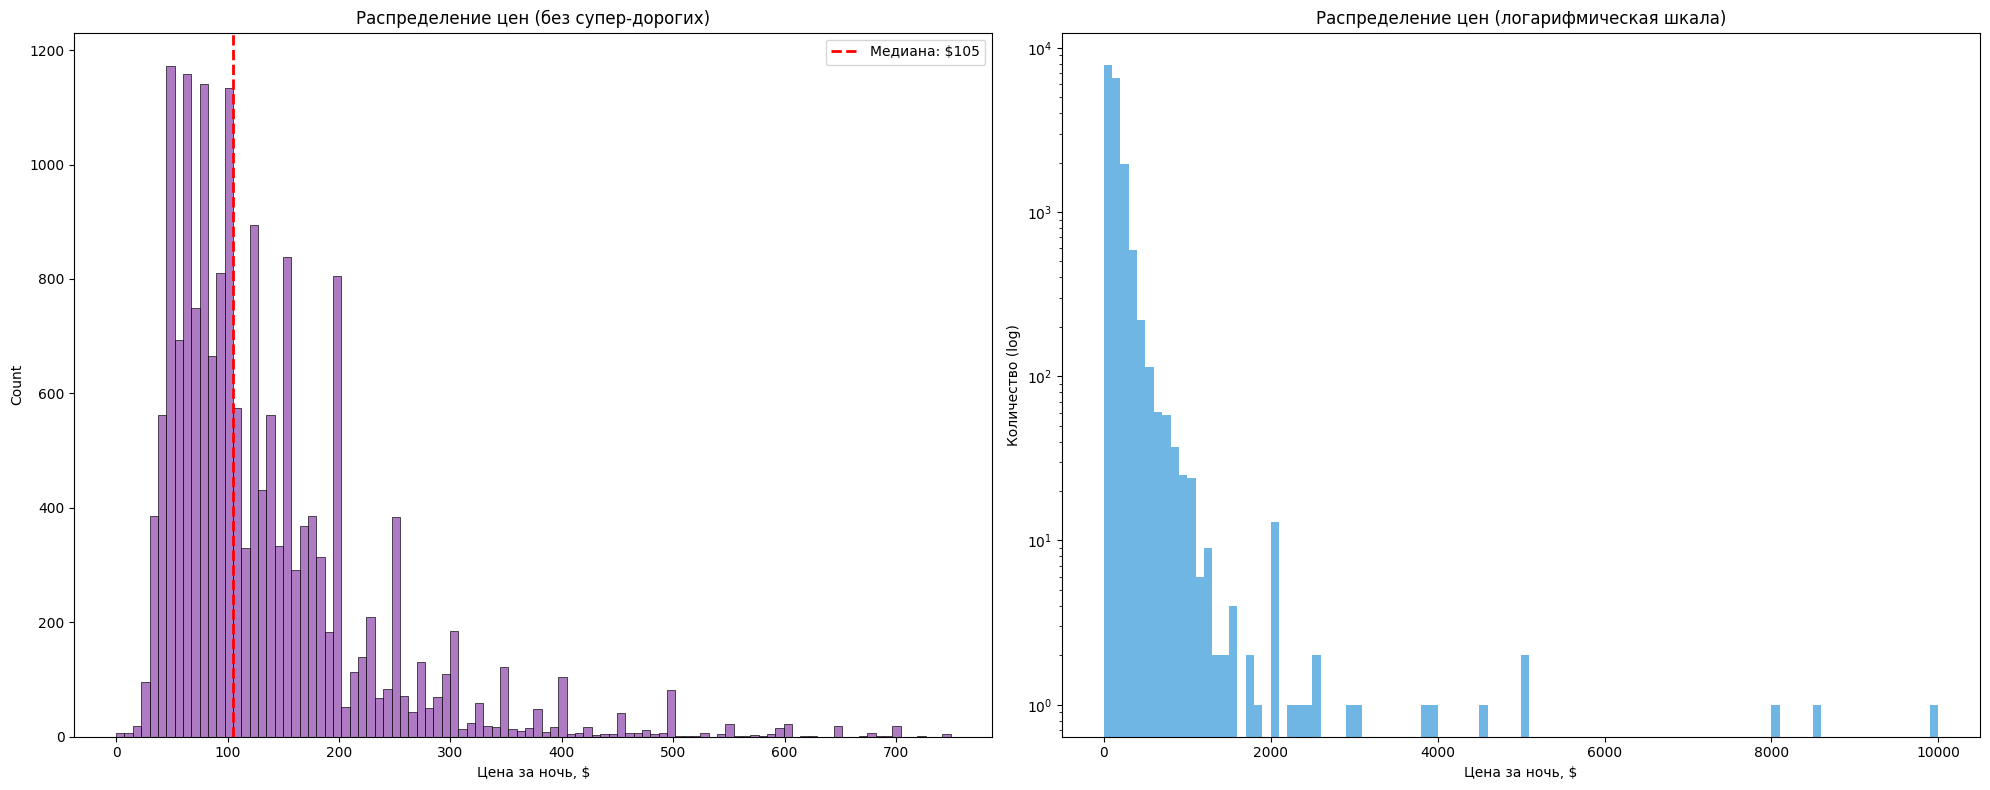

Средняя цена: $145.46
Медианная цена: $109.00
Макс цена: $9999.00
99% квантиль: $750.00


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Обычная гистограмма (с обрезкой выбросов)
ny_filtered = ny[ny['price'] < ny['price'].quantile(0.99)]  # убираем топ-1%
sns.histplot(ny_filtered['price'], bins=100, ax=axes[0], color='#9b59b6', alpha=0.8)
axes[0].set_title('Распределение цен (без супер-дорогих)')
axes[0].set_xlabel('Цена за ночь, $')
axes[0].axvline(ny_filtered['price'].median(), color='red', linestyle='--', linewidth=2, label=f"Медиана: ${ny_filtered['price'].median():.0f}")
axes[0].legend()

# Логарифмическая шкала
axes[1].hist(ny['price'], bins=100, color='#3498db', alpha=0.7, log=True)
axes[1].set_title('Распределение цен (логарифмическая шкала)')
axes[1].set_xlabel('Цена за ночь, $')
axes[1].set_ylabel('Количество (log)')

plt.tight_layout()
plt.show()

print(f"Средняя цена: ${ny['price'].mean():.2f}")
print(f"Медианная цена: ${ny['price'].median():.2f}")
print(f"Макс цена: ${ny['price'].max():.2f}")
print(f"99% квантиль: ${ny['price'].quantile(0.99):.2f}")

C:\Users\fedor\AppData\Local\Temp\ipykernel_28484\4140587318.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_neigh.values, y=top_neigh.index, palette='viridis')


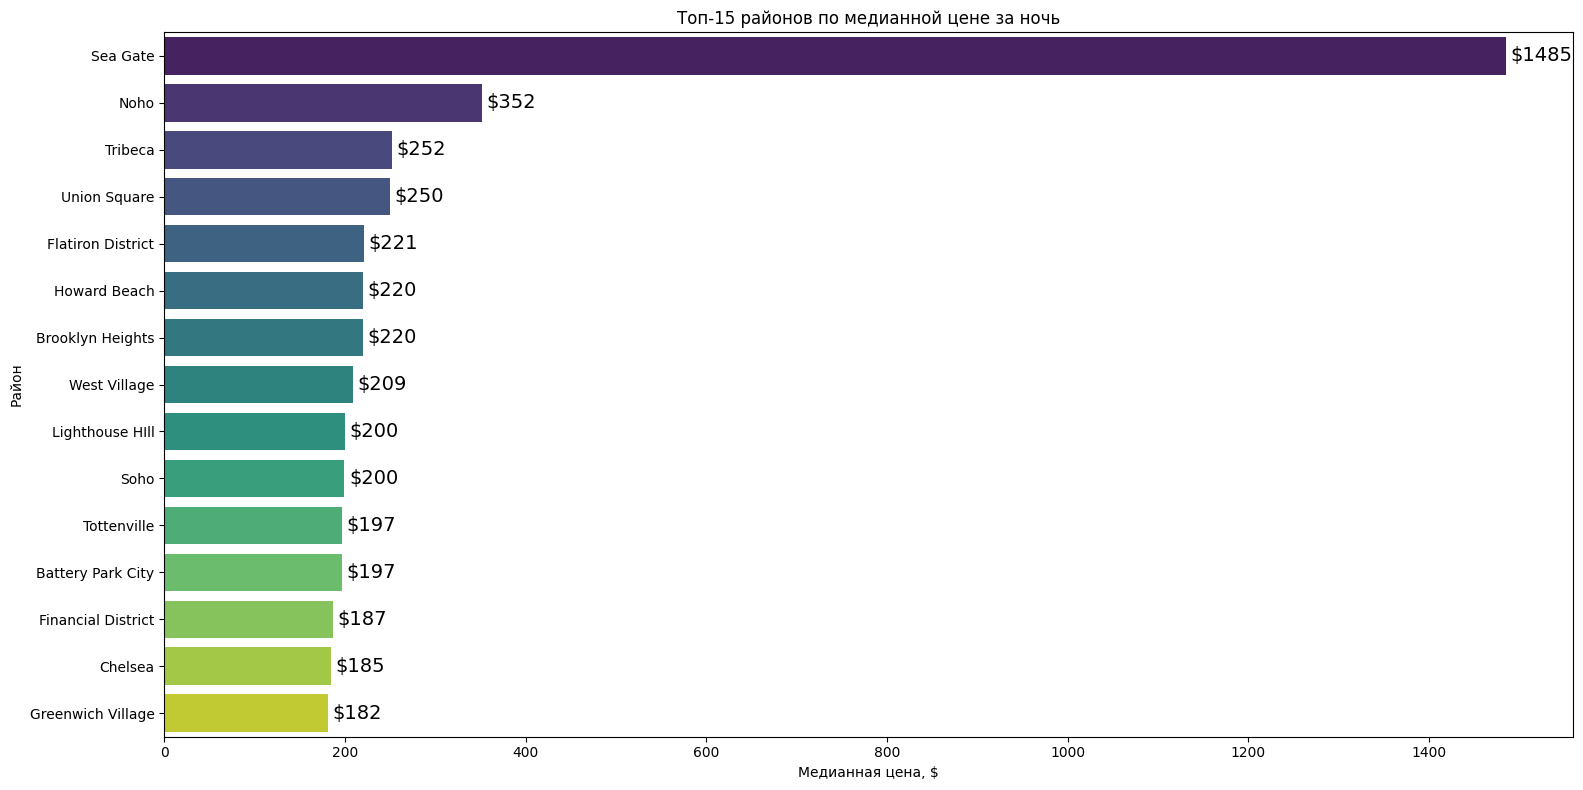

In [10]:
# Топ-15 районов по медианной цене
top_neigh = ny.groupby('neighbourhood')['price'].median().sort_values(ascending=False).head(15)

plt.figure(figsize=(16, 8))
sns.barplot(x=top_neigh.values, y=top_neigh.index, palette='viridis')
plt.title('Топ-15 районов по медианной цене за ночь')
plt.xlabel('Медианная цена, $')
plt.ylabel('Район')
for i, v in enumerate(top_neigh.values):
    plt.text(v + 5, i, f"${v:.0f}", va='center', fontsize=14)

plt.tight_layout()
plt.show()

## Предобработка текста отзывов

In [11]:
# Предобработка текста
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Добавлние самых частых и бесполезных слов
extra_stops = {"the", "and", "was", "were", "is", "are", "been", "it'", "it's", "place", "food", "nt"}
stop_words.update(extra_stops)

def clean_and_lemmatize_fast(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)         
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words 
             if w not in stop_words and len(w) > 2]
    return " ".join(words)

reviews['Review_clean'] = reviews['Review'].apply(clean_and_lemmatize_fast)

reviews[['Review', 'Review_clean', 'Liked']].head(10)

,Review,Review_clean,Liked
0,Wow... Loved this place.,wow loved,1
1,Crust is not good.,crust good,0
2,Not tasty and the texture was just nasty.,tasty texture nasty,0
3,Stopped by during the late May bank holiday of...,stopped late may bank holiday rick steve recom...,1
4,The selection on the menu was great and so wer...,selection menu great price,1
5,Now I am getting angry and I want my damn pho.,getting angry want damn pho,0
6,Honeslty it didn't taste THAT fresh.),honeslty didnt taste fresh,0
7,The potatoes were like rubber and you could te...,potato like rubber could tell made ahead time ...,0
8,The fries were great too.,fry great,1
9,A great touch.,great touch,1


In [12]:
    # Векторизация текста с TF-IDF

    from sklearn.feature_extraction.text import TfidfVectorizer

    vectorizer = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True,
        stop_words='english'
    )

    X_text = vectorizer.fit_transform(reviews['Review_clean'])
    y_text = reviews['Liked']

    print(f"Размер матрицы: {X_text.shape}")
    print(f"Пример слов: {list(vectorizer.vocabulary_.keys())[:20]}")

Размер матрицы: (1000, 445)
Пример слов: ['wow', 'loved', 'good', 'tasty', 'texture', 'nasty', 'recommendation', 'selection', 'menu', 'great', 'price', 'getting', 'want', 'damn', 'pho', 'didnt', 'taste', 'fresh', 'potato', 'like']


In [13]:
# Разделение на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(
    X_text, y_text, test_size=0.2, random_state=42, stratify=y_text
)

print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# Создаём список для сбора результатов 
results = []

Train size: 800, Test size: 200


XGBoost → Accuracy: 0.7400 | F1: 0.7263 | ROC-AUC: 0.8309


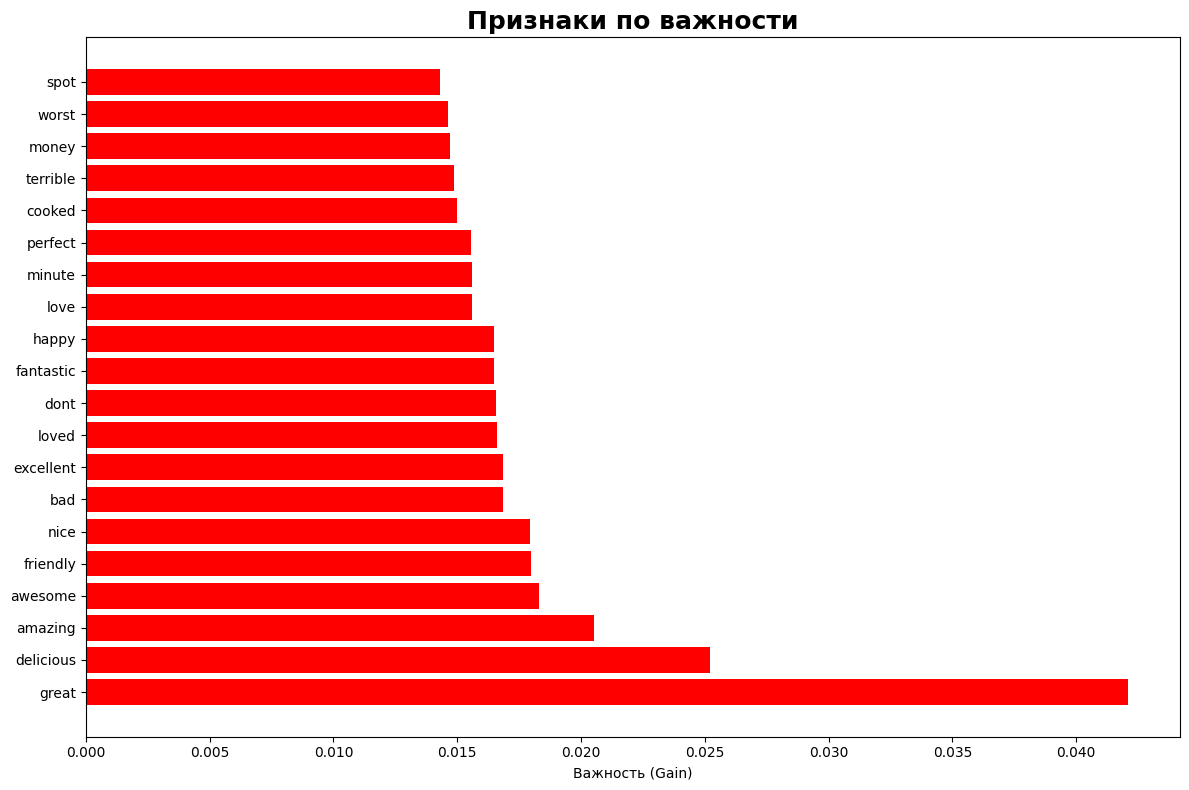

 1. great                → 0.0421
 2. delicious            → 0.0252
 3. amazing              → 0.0205
 4. awesome              → 0.0183
 5. friendly             → 0.0180
 6. nice                 → 0.0179
 7. bad                  → 0.0168
 8. excellent            → 0.0168
 9. loved                → 0.0166
10. dont                 → 0.0166
11. fantastic            → 0.0165
12. happy                → 0.0165
13. love                 → 0.0156
14. minute               → 0.0156
15. perfect              → 0.0156
16. cooked               → 0.0150
17. terrible             → 0.0149
18. money                → 0.0147
19. worst                → 0.0146
20. spot                 → 0.0143


In [19]:
# Бейзлайн: XGBoost Classifier

xgb_clf = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    verbosity=0
)

xgb_clf.fit(X_train, y_train)

pred = xgb_clf.predict(X_test)
proba = xgb_clf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, pred)
f1  = f1_score(y_test, pred)

print(f"XGBoost → Accuracy: {acc:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc_score(y_test, proba):.4f}")

results.append({
    'Задача': 'Классификация',
    'Этап': 'Градиентный бустинг',
    'Модель': 'XGBoost',
    'Accuracy': acc,
    'F1': f1
})

importances = xgb_clf.feature_importances_
indices = np.argsort(importances)[::-1][:20]
feature_names = vectorizer.get_feature_names_out()

plt.figure(figsize=(12, 8))
plt.title("Признаки по важности", fontsize=18, fontweight='bold')
plt.barh(range(len(indices)), importances[indices][::-1], color='red')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices][::-1])
plt.xlabel("Важность (Gain)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

for i, idx in enumerate(indices, 1):
    print(f"{i:2d}. {feature_names[idx]:<20} → {importances[idx]:.4f}")

In [20]:
features_reg = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                'reviews_per_month', 'availability_2020', 'days_occupied_in_2019']
X_reg = ny[features_reg].fillna(0)
y_reg = ny['price']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)


XGBoost → MAE:  71.12
XGBoost → RMSE: 172.70

Важность:


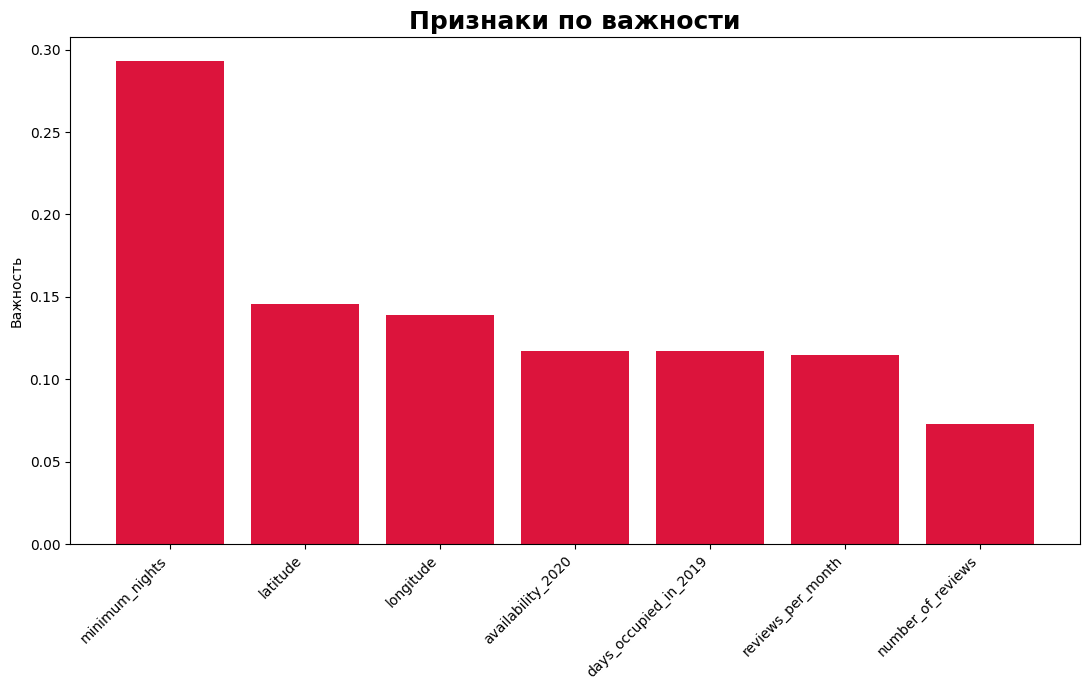

1. minimum_nights       → 0.2928
2. latitude             → 0.1460
3. longitude            → 0.1393
4. availability_2020    → 0.1172
5. days_occupied_in_2019 → 0.1170
6. reviews_per_month    → 0.1149
7. number_of_reviews    → 0.0729


In [23]:
# xgboost regressor

xgb_reg = xgb.XGBRegressor(
    n_estimators=600,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    eval_metric='mae'
)

xgb_reg.fit(X_train_r, y_train_r)

pred_reg = xgb_reg.predict(X_test_r)

mae_final = mean_absolute_error(y_test_r, pred_reg)
rmse_final = np.sqrt(mean_squared_error(y_test_r, pred_reg))

print(f"\nXGBoost → MAE:  {mae_final:.2f}")
print(f"XGBoost → RMSE: {rmse_final:.2f}")

results.append({
    'Задача': 'Регрессия',
    'Этап': 'Градиентный бустинг',
    'Модель': 'XGBoost',
    'MAE': mae_final,
    'RMSE': rmse_final
})
print("\nВажность:")
importances = xgb_reg.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(11, 7))
plt.title("Признаки по важности", fontsize=18, fontweight='bold')
plt.bar(range(len(importances)), importances[indices], color='crimson')
plt.xticks(range(len(importances)), [features_reg[i] for i in indices], rotation=45, ha='right')
plt.ylabel("Важность")
plt.tight_layout()
plt.show()

for i, idx in enumerate(indices):
    print(f"{i+1}. {features_reg[idx]:<20} → {importances[idx]:.4f}")

Accuracy:    0.7350
F1-score:    0.7196
ROC-AUC:     0.7974


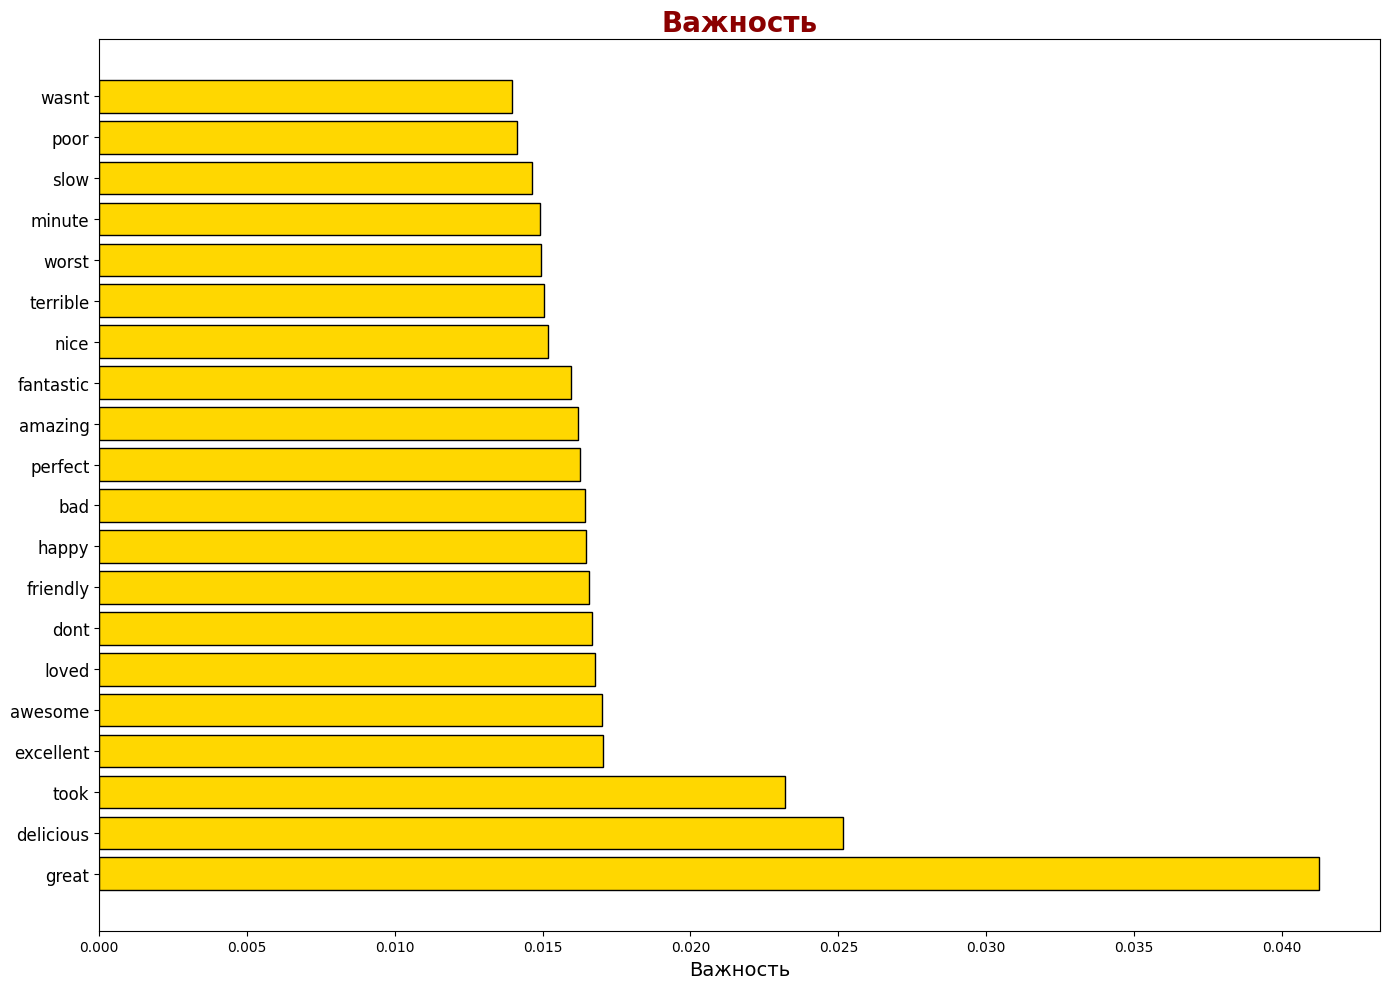

 1. great                → 0.0413
 2. delicious            → 0.0251
 3. took                 → 0.0232
 4. excellent            → 0.0170
 5. awesome              → 0.0170
 6. loved                → 0.0168
 7. dont                 → 0.0167
 8. friendly             → 0.0166
 9. happy                → 0.0165
10. bad                  → 0.0164
11. perfect              → 0.0163
12. amazing              → 0.0162
13. fantastic            → 0.0160
14. nice                 → 0.0152
15. terrible             → 0.0151
16. worst                → 0.0149
17. minute               → 0.0149
18. slow                 → 0.0146
19. poor                 → 0.0141
20. wasnt                → 0.0140


In [24]:
# xgboost classifier 

vectorizer_imp = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=5000,
    sublinear_tf=True,
    stop_words='english'
)

X_clf_imp = vectorizer_imp.fit_transform(reviews['Review_clean'])
y_clf = reviews['Liked']

X_train_c2, X_test_c2, y_train_c2, y_test_c2 = train_test_split(
    X_clf_imp, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

xgb_clf_final = xgb.XGBClassifier(
    n_estimators=800,
    max_depth=10,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    verbosity=0,
    tree_method='hist'  
)

xgb_clf_final.fit(X_train_c2, y_train_c2)

pred = xgb_clf_final.predict(X_test_c2)
proba = xgb_clf_final.predict_proba(X_test_c2)[:, 1]

acc = accuracy_score(y_test_c2, pred)
f1  = f1_score(y_test_c2, pred)
auc = roc_auc_score(y_test_c2, proba)

print(f"Accuracy:    {acc:.4f}")
print(f"F1-score:    {f1:.4f}")
print(f"ROC-AUC:     {auc:.4f}")

results.append({
    'Задача': 'Классификация',
    'Этап': 'УЛУЧШЕННЫЙ + XGBoost',
    'Модель': 'XGBoost',
    'Accuracy': acc,
    'F1': f1
})

importances = xgb_clf_final.feature_importances_
indices = np.argsort(importances)[::-1][:20]
feature_names = vectorizer_imp.get_feature_names_out()

plt.figure(figsize=(14, 10))
plt.title("Важность", fontsize=20, fontweight='bold', color='darkred')
plt.barh(range(len(indices)), importances[indices][::-1], color='gold', edgecolor='black')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices][::-1], fontsize=12)
plt.xlabel("Важность", fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

for i, idx in enumerate(indices, 1):
    print(f"{i:2d}. {feature_names[idx]:<20} → {importances[idx]:.4f}")

MAE:         51.29
RMSE:        84.14


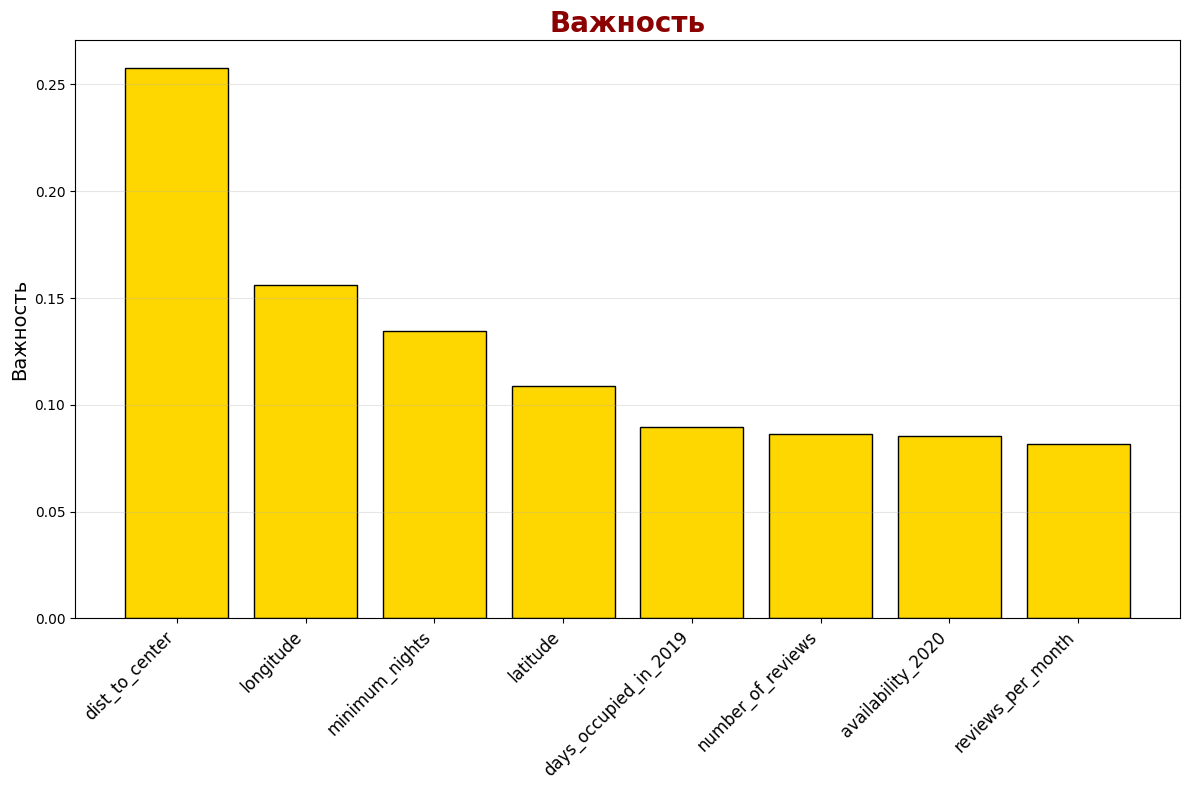

 1. dist_to_center            → 0.2578
 2. longitude                 → 0.1562
 3. minimum_nights            → 0.1344
 4. latitude                  → 0.1090
 5. days_occupied_in_2019     → 0.0894
 6. number_of_reviews         → 0.0865
 7. availability_2020         → 0.0853
 8. reviews_per_month         → 0.0814


In [25]:
# xboost regressor улучшенный


df_reg = ny[(ny['price'] > 10) & (ny['price'] < 800)].copy()
df_reg['log_price'] = np.log1p(df_reg['price'])

times_square_lat = 40.7580
times_square_lon = -73.9855
df_reg['dist_to_center'] = np.sqrt(
    (df_reg['latitude'] - times_square_lat)**2 + 
    (df_reg['longitude'] - times_square_lon)**2
) * 111

features_reg = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                'reviews_per_month', 'availability_2020', 'days_occupied_in_2019', 'dist_to_center']

X_reg_imp = df_reg[features_reg].fillna(0)
y_reg_imp = df_reg['log_price']

X_train_r2, X_test_r2, y_train_r2, y_test_r2 = train_test_split(
    X_reg_imp, y_reg_imp, test_size=0.2, random_state=42
)

xgb_final = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=10,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    eval_metric='mae',
    tree_method='hist'
)

xgb_final.fit(X_train_r2, y_train_r2)

pred_log = xgb_final.predict(X_test_r2)
pred_price = np.expm1(pred_log)
true_price = np.expm1(y_test_r2)

mae_final = mean_absolute_error(true_price, pred_price)
rmse_final = np.sqrt(mean_squared_error(true_price, pred_price))

print(f"MAE:         {mae_final:.2f}")
print(f"RMSE:        {rmse_final:.2f}")

results.append({
    'Задача': 'Регрессия',
    'Этап': 'ФИНАЛ — XGBoost',
    'Модель': 'XGBoost',
    'MAE': mae_final,
    'RMSE': rmse_final
})

importances = xgb_final.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Важность", fontsize=20, fontweight='bold', color='darkred')
plt.bar(range(len(importances)), importances[indices], color='gold', edgecolor='black')
plt.xticks(range(len(importances)), [features_reg[i] for i in indices], rotation=45, ha='right', fontsize=12)
plt.ylabel("Важность", fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

for i, idx in enumerate(indices):
    print(f"{i+1:2d}. {features_reg[idx]:<25} → {importances[idx]:.4f}")

In [29]:
# моя реализация градиентного бустинга

import random

class _BaseTreeRegressor:
    def __init__(self, max_depth=5, min_samples_split=5):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.tree = None
    
    def _mse(self, y):
        return np.var(y) * len(y) if len(y) > 0 else 0
    
    def _best_split(self, X, y):
        best_gain = -1
        best_feat, best_thr = None, None
        n_features = X.shape[1]
        features_to_check = random.sample(range(n_features), min(20, int(np.sqrt(n_features))+1))
        
        for feat in features_to_check:
            thresholds = np.unique(X[:, feat])
            for thr in thresholds:
                left = y[X[:, feat] <= thr]
                right = y[X[:, feat] > thr]
                if len(left) < 2 or len(right) < 2: continue
                gain = self._mse(y) - (self._mse(left) + self._mse(right))
                if gain > best_gain:
                    best_gain, best_feat, best_thr = gain, feat, thr
        return best_feat, best_thr
    
    def _build(self, X, y, depth=0):
        if depth >= self.max_depth or len(y) < self.min_samples_split:
            return np.mean(y)
        feat, thr = self._best_split(X, y)
        if feat is None:
            return np.mean(y)
        left_mask = X[:, feat] <= thr
        left = self._build(X[left_mask], y[left_mask], depth + 1)
        right = self._build(X[~left_mask], y[~left_mask], depth + 1)
        return (feat, thr, left, right)
    
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        self.tree = self._build(X, y)
    
    def _predict_one(self, x, tree):
        if not isinstance(tree, tuple):
            return tree
        feat, thr, left, right = tree
        return self._predict_one(x, left) if x[feat] <= thr else self._predict_one(x, right)
    
    def predict(self, X):
        X = np.array(X)
        return np.array([self._predict_one(x, self.tree) for x in X])
    
class MyGradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_pred = None
    
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        self.initial_pred = np.mean(y)
        residuals = y - self.initial_pred
        
        for i in range(self.n_estimators):
            tree = _BaseTreeRegressor(max_depth=self.max_depth, min_samples_split=2)
            tree.fit(X, residuals)
            self.trees.append(tree)
            update = self.learning_rate * tree.predict(X)
            residuals -= update
            
            if (i+1) % 20 == 0:
                current_pred = self.initial_pred + sum(self.learning_rate * t.predict(X) for t in self.trees)
                mae = mean_absolute_error(y, current_pred)
                print(f"    Дерево {i+1}/{self.n_estimators} → текущий MAE: {mae:.2f}")
    
    def predict(self, X):
        X = np.array(X)
        pred = np.full(X.shape[0], self.initial_pred)
        for tree in self.trees:
            pred += self.learning_rate * tree.predict(X)
        return pred


class MyGradientBoostingClassifier:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_pred = None
    
    def fit(self, X, y):
        X, y = np.array(X), np.array(y)
        self.initial_pred = np.log(np.mean(y) / (1 - np.mean(y) + 1e-8))
        p = 1 / (1 + np.exp(-self.initial_pred))
        residuals = y - p
        
        for i in range(self.n_estimators):
            tree = _BaseTreeRegressor(max_depth=self.max_depth, min_samples_split=2)
            tree.fit(X, residuals)
            self.trees.append(tree)
            
            update = self.learning_rate * tree.predict(X)
            p = 1 / (1 + np.exp(-(self.initial_pred + sum(self.learning_rate * t.predict(X) for t in self.trees))))
            residuals = y - p
            
            if (i+1) % 20 == 0:
                pred_proba = self.predict_proba(X)
                acc = accuracy_score(y, (pred_proba > 0.5).astype(int))
                print(f"    Дерево {i+1}/{self.n_estimators} → текущая Accuracy: {acc:.4f}")
    
    def predict_proba(self, X):
        X = np.array(X)
        log_odds = self.initial_pred + sum(self.learning_rate * t.predict(X) for t in self.trees)
        return 1 / (1 + np.exp(-log_odds))
    
    def predict(self, X):
        return (self.predict_proba(X) > 0.5).astype(int)

In [31]:
# тест классификатора
X_train_c2_arr = X_train_c2.toarray() if hasattr(X_train_c2, 'toarray') else np.array(X_train_c2)
X_test_c2_arr  = X_test_c2.toarray()  if hasattr(X_test_c2,  'toarray') else np.array(X_test_c2)
y_train_np = np.array(y_train_c2)
y_test_np  = np.array(y_test_c2)

my_gb_clf = MyGradientBoostingClassifier(
    n_estimators=120,
    learning_rate=0.08,
    max_depth=5
)

my_gb_clf.fit(X_train_c2_arr, y_train_np)
pred = my_gb_clf.predict(X_test_c2_arr)

acc = accuracy_score(y_test_np, pred)
f1  = f1_score(y_test_np, pred)

print(f"\nМОЙ ГРАДИЕНТНЫЙ БУСТИНГ → Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

results.append({
    'Задача': 'Классификация',
    'Этап': 'СВОЯ РЕАЛИЗАЦИЯ ГРАДИЕНТНОГО БУСТИНГА',
    'Модель': 'MyGradientBoosting',
    'Accuracy': acc,
    'F1': f1
})

    Дерево 20/120 → текущая Accuracy: 0.6488
    Дерево 40/120 → текущая Accuracy: 0.7538
    Дерево 60/120 → текущая Accuracy: 0.8075
    Дерево 80/120 → текущая Accuracy: 0.8588
    Дерево 100/120 → текущая Accuracy: 0.8838
    Дерево 120/120 → текущая Accuracy: 0.9050

МОЙ ГРАДИЕНТНЫЙ БУСТИНГ → Accuracy: 0.7500 | F1-score: 0.7449


In [33]:
# тест регрессора

df_reg = ny[(ny['price'] > 10) & (ny['price'] < 800)].copy()
df_reg['log_price'] = np.log1p(df_reg['price'])

times_square_lat = 40.7580
times_square_lon = -73.9855
df_reg['dist_to_center'] = np.sqrt(
    (df_reg['latitude'] - times_square_lat)**2 + 
    (df_reg['longitude'] - times_square_lon)**2
) * 111

features_reg = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 
                'reviews_per_month', 'availability_2020', 'days_occupied_in_2019', 'dist_to_center']

X_reg = df_reg[features_reg].fillna(0).values
y_reg = df_reg['log_price'].values

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print(f"Данные готовы: {X_train_r.shape[0]} обучающих, {X_test_r.shape[0]} тестовых")

my_gb_reg = MyGradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.08,
    max_depth=4
)

my_gb_reg.fit(X_train_r, y_train_r)

pred_log = my_gb_reg.predict(X_test_r)
pred_price = np.expm1(pred_log)
true_price = np.expm1(y_test_r)

mae = mean_absolute_error(true_price, pred_price)
rmse = np.sqrt(mean_squared_error(true_price, pred_price))

print(f"\nМОЙ ГРАДИЕНТНЫЙ БУСТИНГ (РЕГРЕССИЯ) → MAE: {mae:.2f} | RMSE: {rmse:.2f}")

results.append({
    'Задача': 'Регрессия',
    'Этап': 'СВОЯ РЕАЛИЗАЦИЯ ГРАДИЕНТНОГО БУСТИНГА',
    'Модель': 'MyGradientBoosting',
    'MAE': mae,
    'RMSE': rmse
})

Данные готовы: 13969 обучающих, 3493 тестовых
    Дерево 20/150 → текущий MAE: 0.41
    Дерево 40/150 → текущий MAE: 0.40
    Дерево 60/150 → текущий MAE: 0.39
    Дерево 80/150 → текущий MAE: 0.39
    Дерево 100/150 → текущий MAE: 0.38
    Дерево 120/150 → текущий MAE: 0.38
    Дерево 140/150 → текущий MAE: 0.38

МОЙ ГРАДИЕНТНЫЙ БУСТИНГ (РЕГРЕССИЯ) → MAE: 53.23 | RMSE: 87.15


In [36]:
# финальная таблица результатов

final_df = pd.DataFrame(results)

clf_df = final_df[final_df['Задача'] == 'Классификация'][['Этап', 'Модель', 'Accuracy', 'F1']].round(4)
clf_df = clf_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

display(clf_df.style
        .background_gradient(cmap='Greens', subset=['Accuracy', 'F1'])
        .set_table_styles([{'selector': 'caption',
                            'props': [('font-size', '20pt'), ('font-weight', 'bold'), ('color', 'darkgreen'), ('text-align', 'center')]}]))

reg_df = final_df[final_df['Задача'] == 'Регрессия'][['Этап', 'Модель', 'MAE', 'RMSE']].round(2)
reg_df = reg_df.sort_values('MAE').reset_index(drop=True)

reg_display = reg_df.copy()
reg_display['MAE'] = pd.to_numeric(reg_display['MAE'], errors='coerce')
reg_display['RMSE'] = pd.to_numeric(reg_display['RMSE'], errors='coerce')

display(reg_display.style
        .background_gradient(cmap='Oranges_r', subset=['MAE'])
        .background_gradient(cmap='Blues_r', subset=['RMSE'])
        .set_table_styles([{'selector': 'caption',
                            'props': [('font-size', '20pt'), ('font-weight', 'bold'), ('color', 'darkred'), ('text-align', 'center')]}]))

total_df = final_df[['Задача', 'Модель', 'Этап', 'Accuracy', 'F1', 'MAE', 'RMSE']].round(4)

total_display = total_df.copy()
for col in ['Accuracy', 'F1', 'MAE', 'RMSE']:
    total_display[col] = pd.to_numeric(total_display[col], errors='coerce')

display(total_display.style
        .background_gradient(cmap='RdYlGn', subset=['Accuracy', 'F1'])
        .background_gradient(cmap='RdYlBu_r', subset=['MAE', 'RMSE'])
        .format({'Accuracy': '{:.4f}', 'F1': '{:.4f}', 'MAE': '{:.2f}', 'RMSE': '{:.2f}'}, na_rep='-')
        .set_table_styles([{'selector': 'caption',
                            'props': [('font-size', '24pt'), ('font-weight', 'bold'), ('color', 'purple'), ('text-align', 'center')]}]))

print(f"Классификация → {clf_df.iloc[0]['Модель']} | Accuracy: {clf_df.iloc[0]['Accuracy']} | F1: {clf_df.iloc[0]['F1']}")
print(f"Регрессия     → {reg_df.iloc[0]['Модель']} | MAE: {reg_df.iloc[0]['MAE']}")

,Этап,Модель,Accuracy,F1
0,СВОЯ РЕАЛИЗАЦИЯ ГРАДИЕНТНОГО БУСТИНГА,MyGradientBoosting,0.750000,0.744900
1,Градиентный бустинг,XGBoost,0.740000,0.726300
2,Градиентный бустинг,XGBoost,0.740000,0.726300
3,Градиентный бустинг,XGBoost,0.740000,0.726300
4,УЛУЧШЕННЫЙ + XGBoost,XGBoost,0.735000,0.719600


,Этап,Модель,MAE,RMSE
0,ФИНАЛ — XGBoost,XGBoost,51.290000,84.140000
1,СВОЯ РЕАЛИЗАЦИЯ ГРАДИЕНТНОГО БУСТИНГА,MyGradientBoosting,53.230000,87.150000
2,Градиентный бустинг,XGBoost,71.120000,172.700000
3,Градиентный бустинг,XGBoost,71.120000,172.700000


,Задача,Модель,Этап,Accuracy,F1,MAE,RMSE
0,Классификация,XGBoost,Градиентный бустинг,0.7400,0.7263,-,-
1,Классификация,XGBoost,Градиентный бустинг,0.7400,0.7263,-,-
2,Классификация,XGBoost,Градиентный бустинг,0.7400,0.7263,-,-
3,Регрессия,XGBoost,Градиентный бустинг,-,-,71.12,172.70
4,Регрессия,XGBoost,Градиентный бустинг,-,-,71.12,172.70
5,Классификация,XGBoost,УЛУЧШЕННЫЙ + XGBoost,0.7350,0.7196,-,-
6,Регрессия,XGBoost,ФИНАЛ — XGBoost,-,-,51.29,84.14
7,Классификация,MyGradientBoosting,СВОЯ РЕАЛИЗАЦИЯ ГРАДИЕНТНОГО БУСТИНГА,0.7500,0.7449,-,-
8,Регрессия,MyGradientBoosting,СВОЯ РЕАЛИЗАЦИЯ ГРАДИЕНТНОГО БУСТИНГА,-,-,53.23,87.15


Классификация → MyGradientBoosting | Accuracy: 0.75 | F1: 0.7449
Регрессия     → XGBoost | MAE: 51.29
